## Nitrate above 20 m

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [26]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [41]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, alldepths=False):
    vmax = 36
    vmin = 0
#    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color, ax=ax)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'NO3', 'mod_nitrate')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tspread = spread(temp1[temp1.k >= idepth], 'NO3', 'mod_nitrate')
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(5, 30, 0, 2-np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 34, 0, -2+np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 30, 0, 2-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 34, 0, -2+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 29, 0, 3-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 35, 0, -3+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-0.6, 26, 'bias', rotation=90)
    ax.text(7-0.6, 22, 'systematic', rotation=90)
    ax.text(9-0.6, 19, 'non-systematic', rotation=90)
    if alldepths:
        depthinfo = 'all depths'
    else:
        depthinfo = 'above 20 m'
    ax.set_title(f'{name}, Nitrate {depthinfo}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [11]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [12]:
idepth = 0
jdepth = 18

In [24]:
def plot_one_only(year):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle(f'Year {year}')
    pieces2 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces([pieces2])
    temp2['NO3'] = temp2.N
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, ax)

    fig.savefig(f'surface_nitrate_202111_for_{year}.png')
    
    f = open(f'./surface_nitrate_202111_for_{year}_table.tex', 'w')
    f.write(d202111.to_latex(column_format='lccccccccc',
                             formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    
    return d202111

In [25]:
def plot_compare_year(year):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Year {year}')
    pieces1 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    temp1 = read_pieces([pieces1])
    temp1['NO3'] = temp1.N
    d201905 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0])

    pieces2 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces([pieces2])
    temp2['NO3'] = temp2.N
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1])

    alltogether = pd.concat([d201905, d202111], axis=0)
    fig.savefig(f'surface_nitrate_201905_202111_for_{year}.png')
    
    f = open(f'./surface_nitrate_201905_202111_for_{year}_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccc',
                             formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether

In [45]:
def plot_allyears(lastyear, alldepths=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Year 2007-{lastyear}')
    pieces1 = []
    for year in range(2007, lastyear+1):
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    temp1 = read_pieces(pieces1)
    temp1['NO3'] = temp1.N
    if alldepths:
        d201905 = plot_and_stats(temp1, '201905R', 0, 39, fig, axs[0], alldepths=True)
    else:
        d201905 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0])

    pieces2 = []
    for year in range(2007, lastyear+1):
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces(pieces2)
    temp2['NO3'] = temp2.N
    if alldepths:
        d202111 = plot_and_stats(temp2, '202111', 0, 39, fig, axs[1], alldepths=True)
    else:
        d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1])

    alltogether = pd.concat([d201905, d202111], axis=0)
    
    if alldepths:
        filestub = 'alldepths'
    else:
        filestub = 'surface'
        
    fig.savefig(f'{filestub}_nitrate_201905_202111_for_allyears.png')
    
    f = open(f'./{filestub}_nitrate_201905_202111_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,434,-1.1,6.4,0.13,0.41,7.4,3.8,5.2,0.17


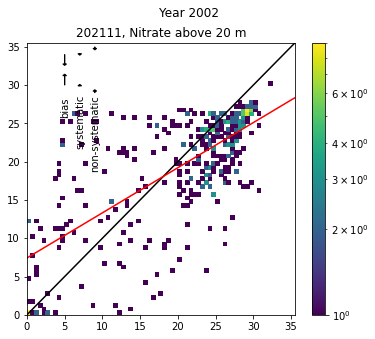

In [28]:
results = plot_one_only(2002)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,285,-1.0,4.6,0.054,0.27,3.7,2.5,3.9,0.12


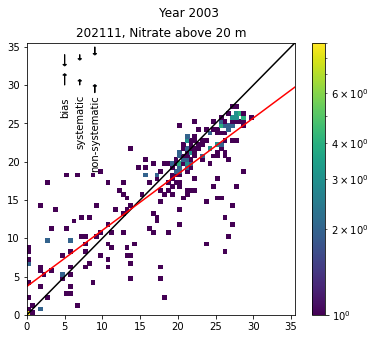

In [29]:
results = plot_one_only(2003)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,243,1.0,5.3,0.077,0.36,7.0,3.7,3.8,0.38


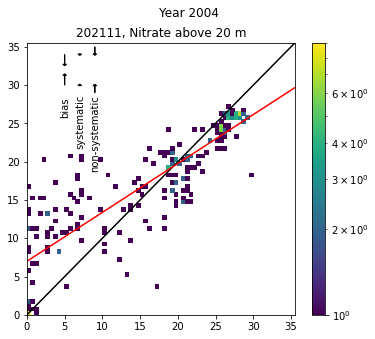

In [30]:
results = plot_one_only(2004)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,312,1.1,5.3,0.11,0.42,8.7,3.6,3.9,0.33


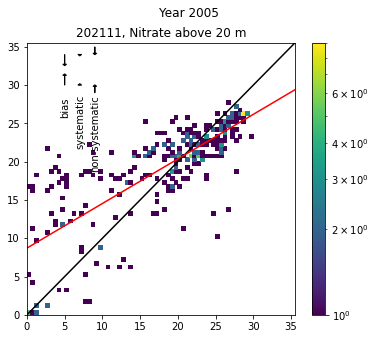

In [31]:
results = plot_one_only(2005)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,286,0.029,5.6,0.092,0.38,7.1,3.3,4.5,0.17


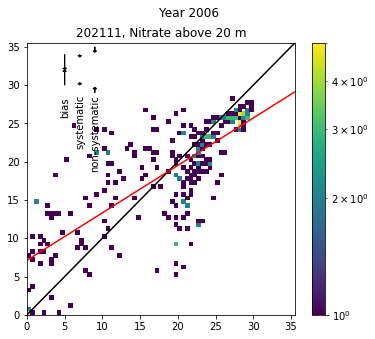

In [32]:
results = plot_one_only(2006)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,286,0.029,5.6,0.092,0.38,7.1,3.3,4.5,0.17


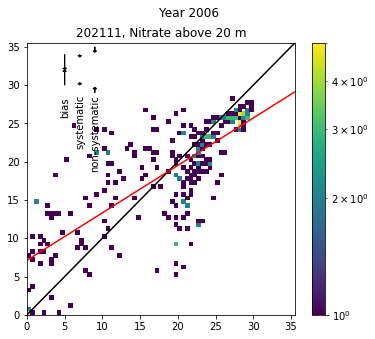

In [19]:
results = plot_one_only(2006)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,233,-0.73,4.3,0.091,0.22,3.8,1.9,3.9,0.14
202111,233,-1.0,3.7,0.077,0.21,3.1,1.9,3.2,0.12


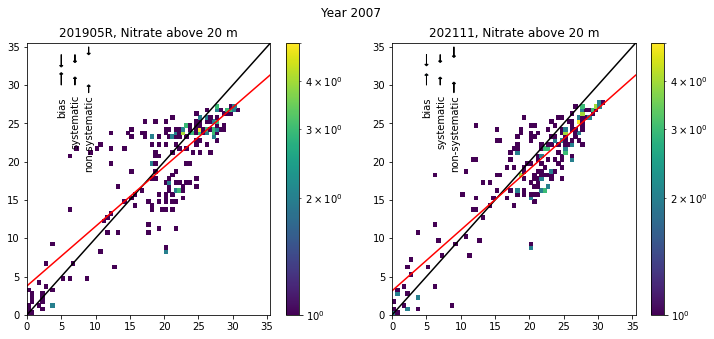

In [33]:
alltogether = plot_compare_year(2007)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,308,-0.95,6.2,0.087,0.36,5.6,3.3,5.3,0.083
202111,308,-0.008,5.2,0.067,0.34,6.2,3.0,4.2,0.2


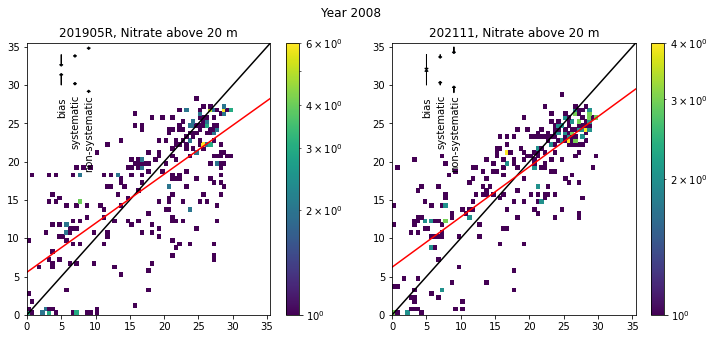

In [34]:
alltogether = plot_compare_year(2008)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,278,0.9,5.7,0.075,0.33,6.6,3.0,4.9,0.24
202111,278,0.3,5.2,0.065,0.37,6.7,3.3,4.1,0.28


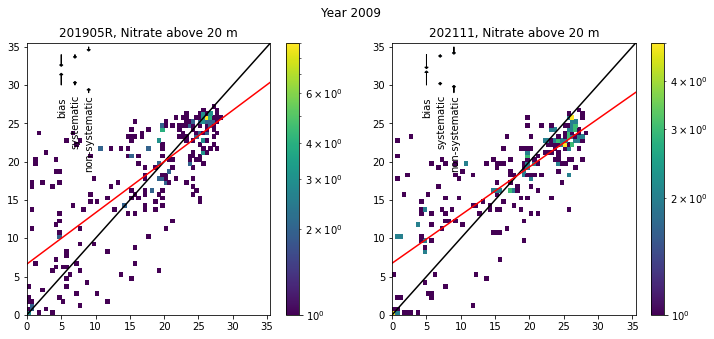

In [47]:
alltogether = plot_compare_year(2009)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,390,0.72,5.2,0.054,0.31,5.4,2.8,4.3,0.34
202111,390,0.12,4.5,0.045,0.27,4.2,2.4,3.9,0.32


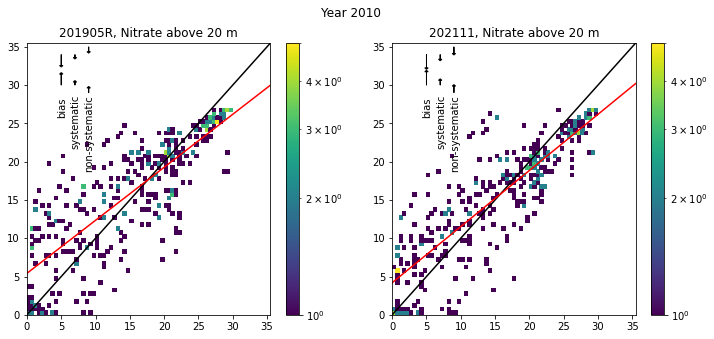

In [35]:
alltogether = plot_compare_year(2010)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,449,1.2,7.0,0.099,0.33,6.7,3.2,6.2,0.13
202111,449,0.77,5.1,0.055,0.32,6.1,3.0,4.2,0.21


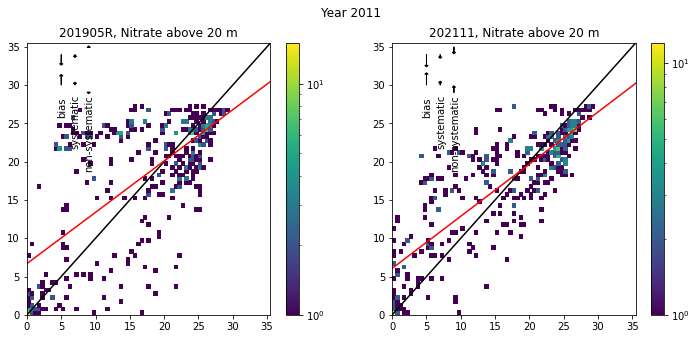

In [36]:
alltogether = plot_compare_year(2011)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,476,0.25,5.2,0.056,0.18,3.3,1.7,4.9,0.12
202111,476,0.07,4.0,0.042,0.28,4.7,2.6,3.1,0.23


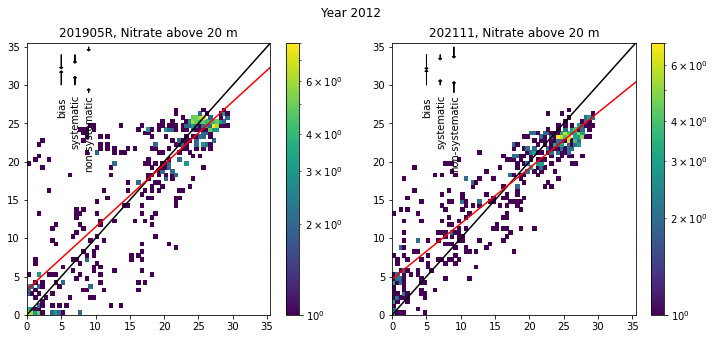

In [38]:
alltogether = plot_compare_year(2012)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,321,-1.2,5.5,0.084,0.38,5.1,3.5,4.2,0.28
202111,318,-0.43,5.4,0.077,0.41,6.4,3.5,4.0,0.3


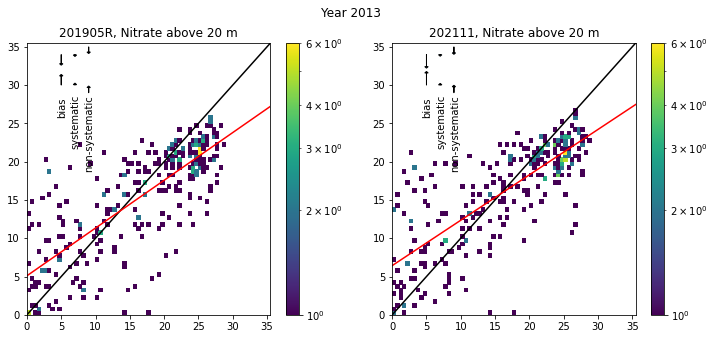

In [48]:
alltogether = plot_compare_year(2013)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,438,-2.5,5.7,0.075,0.32,2.6,3.8,4.3,0.2
202111,438,-0.89,4.6,0.06,0.33,4.4,3.1,3.4,0.31


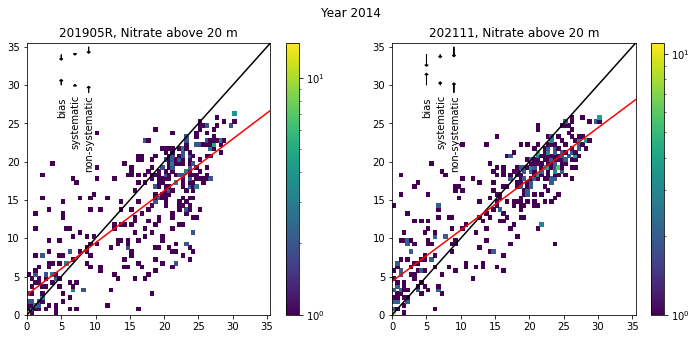

In [51]:
alltogether = plot_compare_year(2014)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,141,-0.72,5.0,0.069,0.26,2.9,2.1,4.6,0.21
202111,141,0.047,4.6,0.06,0.26,3.6,2.0,4.2,0.25


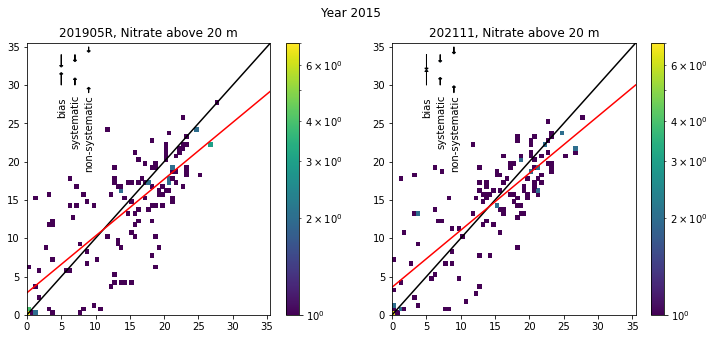

In [54]:
alltogether = plot_compare_year(2015)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,3034,-0.28,5.7,0.074,0.29,4.6,2.6,5.1,0.18
202111,3031,-0.085,4.7,0.057,0.31,5.1,2.7,3.9,0.24


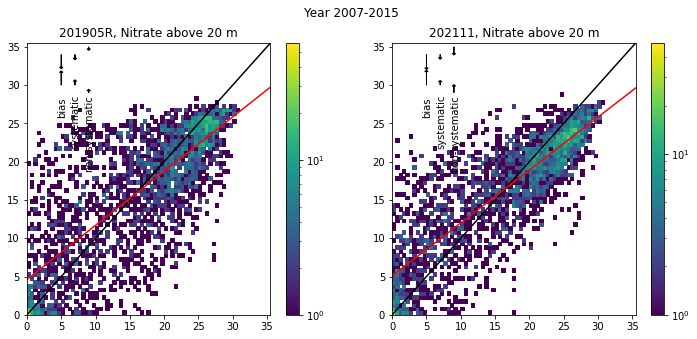

In [55]:
alltogether = plot_allyears(2015)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,10480,-0.91,3.9,0.074,0.21,4.3,1.9,3.4,0.18
202111,10477,-0.79,3.4,0.057,0.21,4.5,1.8,2.8,0.24


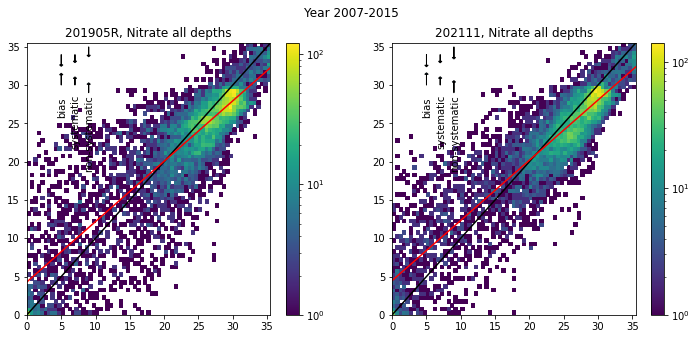

In [56]:
alltogether = plot_allyears(2015, alldepths=True)
alltogether.style.format(myformat).apply(highlight_max_min)